<a href="https://colab.research.google.com/github/hansuho113/SwUniv_CancerAnalysis/blob/main/Colab_Notebook/Suho/cancer_ML_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score

# import mglearn

# Dataset

In [4]:
original_df = pd.read_csv("/content/drive/MyDrive/SW21Project/drug_gene_preprocessed.csv")

## Data Preprocessing

In [5]:
df = original_df.copy()

# ?로 시작하는 gene_exp 관련 컬럼 및 불필요한 컬럼 제거
df.drop(df.columns[7:36], axis=1, inplace=True)
df.drop(['measure_of_response', 'bcr_patient_barcode'], axis=1, inplace=True)
df.rename(columns={'index':'patient_barcode'}, inplace=True)

# one_hot_encoding
df = pd.get_dummies(df,
               prefix=['drugname', 'indication', 'therapy_types'],
               columns=['drug_name_', 'regimen_indication', 'therapy_types'])

In [6]:
df.head(2)

,patient_barcode,therapy_response,A1BG|1,A1CF|29974,A2BP1|54715,A2LD1|87769,A2M|2,A2ML1|144568,A4GALT|53947,A4GNT|51146,AAA1|404744,AAAS|8086,AACS|65985,AACSL|729522,AADAC|13,AADACL2|344752,AADACL3|126767,AADACL4|343066,AADAT|51166,AAGAB|79719,AAK1|22848,AAMP|14,AANAT|15,AARS|16,AARS2|57505,AARSD1|80755,AASDH|132949,AASDHPPT|60496,AASS|10157,AATF|26574,AATK|9625,ABAT|18,ABCA10|10349,ABCA1|19,ABCA11P|79963,ABCA12|26154,ABCA13|154664,ABCA17P|650655,ABCA2|20,ABCA3|21,...,ZSCAN5A|79149,ZSCAN5B|342933,ZSWIM1|90204,ZSWIM2|151112,ZSWIM3|140831,ZSWIM4|65249,ZSWIM5|57643,ZSWIM6|57688,ZSWIM7|125150,ZUFSP|221302,ZW10|9183,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,drugname_bevacizumab,drugname_capecitabine,drugname_fluorouracil,drugname_folinic,drugname_irinotecan,drugname_oxaliplatin,indication_ADJUVANT,"indication_OTHER, SPECIFY IN NOTES",indication_PROGRESSION,indication_RECURRENCE,indication_unknown,therapy_types_Ancillary,therapy_types_Chemotherapy,therapy_types_Immunotherapy,"therapy_types_Other, specify in notesAncillary","therapy_types_Other, specify in notesAncillary Agent","therapy_types_Other, specify in notesancillary",therapy_types_Targeted Molecular therapy,therapy_types_unknown
0,TCGA-A6-6648-01A-11R-1774-07,unknown,6.7929,191.614,6.8615,101.741,4753.24,0.2541,48.0305,0.0,0.2541,748.92,951.207,0.0,3.5578,0.2541,0.0,0.0,215.248,1728.08,995.68,2034.31,0.2541,2742.82,702.9,718.17,212.707,1094.28,79.0343,1883.61,48.0305,855.146,7.6239,616.768,84.6074,3.3037,21.3469,1.7789,576.62,61.4994,...,134.435,1.7789,518.678,0.0,309.022,240.661,703.939,488.437,110.066,233.799,892.503,940.455,1146.63,66.8361,558.577,988.31,1.0165,1029.22,2791.87,2283.1,1205.59,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,TCGA-A6-6648-01A-11R-1774-07,unknown,6.7929,191.614,6.8615,101.741,4753.24,0.2541,48.0305,0.0,0.2541,748.92,951.207,0.0,3.5578,0.2541,0.0,0.0,215.248,1728.08,995.68,2034.31,0.2541,2742.82,702.9,718.17,212.707,1094.28,79.0343,1883.61,48.0305,855.146,7.6239,616.768,84.6074,3.3037,21.3469,1.7789,576.62,61.4994,...,134.435,1.7789,518.678,0.0,309.022,240.661,703.939,488.437,110.066,233.799,892.503,940.455,1146.63,66.8361,558.577,988.31,1.0165,1029.22,2791.87,2283.1,1205.59,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [119]:
data = np.array(df[df.columns.difference(['patient_barcode', 'therapy_response'])])
target = np.array(df.therapy_response)
np.asarray(data).astype('float32')

# label encoding on target array
encoder = LabelEncoder()
encoder.fit(target)
labels = encoder.transform(target)
target = labels

# split the data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=2021)

In [8]:
print(f"""
X_train dataset: {X_train.shape}
X_test dataset: {X_test.shape}

y_train dataset: {y_train.shape}
y_test dataset: {y_test.shape}
""")


X_train dataset: (196, 20521)
X_test dataset: (49, 20521)

y_train dataset: (196,)
y_test dataset: (49,)



# Modeling

## Support Vector Machine Classifier

In [11]:
# hyper parameter tuning
svc_param_grid = {"C": [0.0001, 0.001, 0.01, 1, 10, 100, 1000],
              "gamma": [0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
grid_search_svc = GridSearchCV(SVC(),
                           svc_param_grid,
                           scoring='accuracy',
                           cv=5,
                           return_train_score=True,
                           n_jobs=-1,
                           verbose=1)
grid_search_svc.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [21]:
print(f"test set score: {np.round(grid_search_svc.score(X_test, y_test), 4)}")

print(f"best parameters: {grid_search_svc.best_params_}")
print(f"bset score: {np.round(grid_search_svc.best_score_, 4)}")

test set score: 0.898
best parameters: {'C': 100, 'gamma': 0.01}
bset score: 0.8978


In [9]:
svc = SVC(C=100, gamma=0.01)
svc.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [10]:
svc_pred = svc.predict(X_test)

In [11]:
svc_accuracy = accuracy_score(y_test, svc_pred)
svc_f1 = f1_score(y_test, svc_pred, average='micro')

print(f"Accuracy: {svc_accuracy*100 :.4f}")
print(f"F1: {svc_f1*100 :.4f}")

Accuracy: 89.7959
F1: 89.7959


## Random Forest Classifier

In [15]:
rf = RandomForestClassifier(random_state=2021)

In [16]:
rf_param_grid = {"n_estimators": [100, 300, 500, 700],
                 "max_depth": [6, 8, 10, 12],
                 "min_samples_leaf": [3, 5, 7, 10], 
                 "min_samples_split": [3, 5, 7, 10]}

In [17]:
grid_search_rf = GridSearchCV(rf,
                              param_grid=rf_param_grid,
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed: 21.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [19]:
print(f"test set score: {np.round(grid_search_rf.score(X_test, y_test), 4)}")

print(f"best parameters: {grid_search_rf.best_params_}")
print(f"bset score: {np.round(grid_search_rf.best_score_, 4)}")

test set score: 0.8571
best parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 500}
bset score: 0.8977


In [12]:
rf = RandomForestClassifier(n_estimators=500,
                            min_samples_leaf=3,
                            min_samples_split=10,
                            max_depth=6,
                            max_leaf_nodes=16)

rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)

print(f"RandomForestClassifier Predict Accuracy: {metrics.accuracy_score(y_test, rf_y_pred)}")

RandomForestClassifier Predict Accuracy: 0.8367346938775511


In [13]:
rf_pred = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, svc_pred)
rf_f1 = f1_score(y_test, rf_pred, average='micro')

print(f"Accuracy: {rf_accuracy*100 :.4f}")
print(f"F1: {rf_f1*100 :.4f}")

Accuracy: 89.7959
F1: 83.6735


In [39]:
feature_importances = rf.feature_importances_

ft_importances = pd.Series(feature_importances, index=df[df.columns.difference(['patient_barcode', 'therapy_response'])].columns)
ft_importances = ft_importances.sort_values(ascending=False)

feature_df = pd.DataFrame(ft_importances[:20], columns=["importance"])

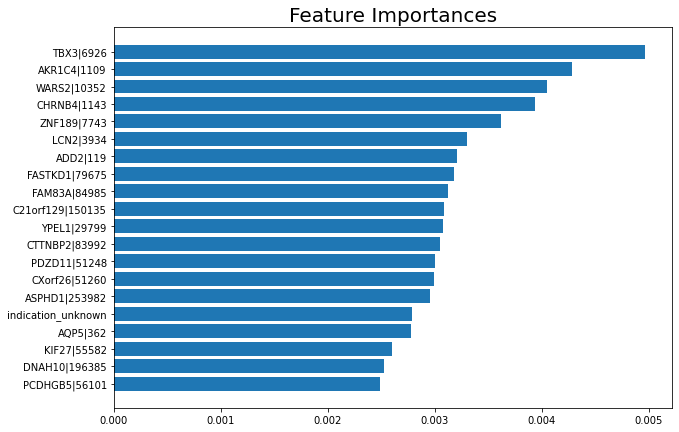

In [42]:
plt.figure(figsize=(10, 7))
plt.barh(feature_df.index.tolist(), feature_df.iloc[:,0].sort_values(ascending=True))
plt.title("Feature Importances", fontsize=20)
plt.show()

## Multi Layer Perceptron

In [111]:
# y_train = tf.keras.utils.to_categorical(y_train, 3)
# y_test = tf.keras.utils.to_categorical(y_test, 3)

In [130]:
mlp_model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [131]:
history = mlp_model.fit(X_train, y_train,
                        epochs=500,
                        validation_split=0.2)

Epoch 1/500
5/5 [==============================] - 15s 135ms/step - loss: 19159.8330 - accuracy: 0.3938 - val_loss: 15048.6904 - val_accuracy: 0.5500
Epoch 2/500
5/5 [==============================] - 0s 25ms/step - loss: 11189.0902 - accuracy: 0.5059 - val_loss: 11194.9014 - val_accuracy: 0.5500
Epoch 3/500
5/5 [==============================] - 0s 24ms/step - loss: 7912.0840 - accuracy: 0.5706 - val_loss: 5638.3101 - val_accuracy: 0.5500
Epoch 4/500
5/5 [==============================] - 0s 24ms/step - loss: 4727.3067 - accuracy: 0.4435 - val_loss: 4631.0859 - val_accuracy: 0.5500
Epoch 5/500
5/5 [==============================] - 0s 23ms/step - loss: 4444.7210 - accuracy: 0.6394 - val_loss: 2317.0220 - val_accuracy: 0.5750
Epoch 6/500
5/5 [==============================] - 0s 23ms/step - loss: 1665.9776 - accuracy: 0.5349 - val_loss: 3128.2148 - val_accuracy: 0.5750
Epoch 7/500
5/5 [==============================] - 0s 24ms/step - loss: 1821.2480 - accuracy: 0.6848 - val_loss: 1239.

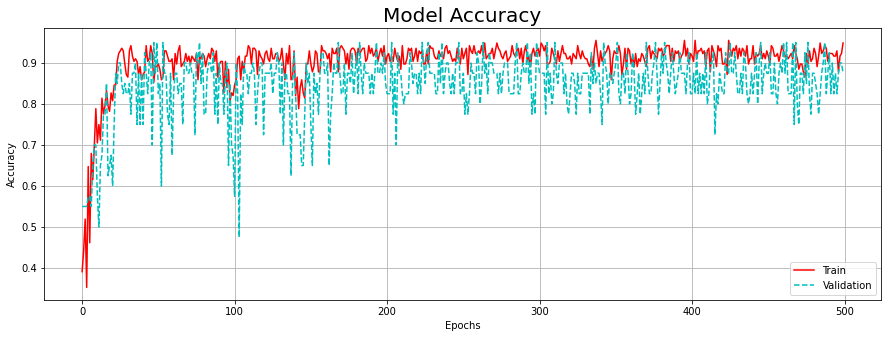

In [144]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'c--')
plt.title("Model Accuracy", fontsize=20)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

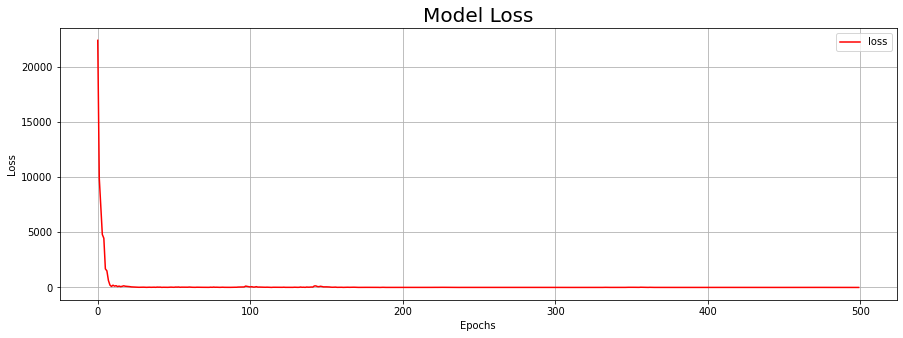

In [147]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], 'r')
plt.legend(['loss'])
plt.title("Model Loss", fontsize=20)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid()
plt.show()